In [402]:
from IPython.display import display

from pytorch_grad_cam import (
    GradCAM,
    HiResCAM,
    ScoreCAM,
    GradCAMPlusPlus,
    AblationCAM,
    XGradCAM,
    EigenCAM,
    FullGrad,
)
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.image import (
    show_cam_on_image,
    deprocess_image,
    preprocess_image,
)
import torch
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np
import cv2

In [403]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define the transformation to be applied to the test images
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

Using mps device


In [404]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# Specify the path to the test set folder
testset_path0 = "../storage/images/more_apples/original_test"

# Specify the path to the saved trained model
model_path0 = "../hall_of_fame/100 accuracy on validation 91.7 on test/20230616-152021_resnet18_more_pinky_loss.pt"


testset_path1 = "../storage/images/stripped/more_test/test"
model_path1 = "../hall_of_fame/100 accuracy on validation 91.7 on test/20230616-152021_resnet18_more_pinky_loss.pt"


In [405]:
# Load the trained model
model = torch.load(model_path0)
model.to(device)
model.eval()


# define the lists of false positives and false negatives in a dataset
def img_check_setup(testset_path, model, device=device, transform=transform):
    # Create the test set dataset
    testset = ImageFolder(testset_path, transform=transform)

    # Lists to store mislabeled images
    mislabeled_fresh_apples = []
    mislabeled_spoiled_apples = []

    # Iterate over the images in the test set
    for image_path, label in testset.imgs:
        # Load and preprocess the image
        image = transform(Image.open(image_path)).unsqueeze(0).to(device)

        # Forward pass through the model
        with torch.no_grad():
            output = model(image)

        # Get the predicted label
        _, predicted_label = torch.max(output, 1)

        # Compare the predicted label with the ground truth label
        if predicted_label != label:
            if label == 0:  # Fresh Apples
                mislabeled_fresh_apples.append(image_path[len(testset_path) :])
            elif label == 1:  # Spoiled Apples
                mislabeled_spoiled_apples.append(image_path[len(testset_path) :])

    return mislabeled_fresh_apples, mislabeled_spoiled_apples


# diplays a list and its 'name'
def img_check_show(imgcheck):
    variable_name = [name for name in globals() if globals()[name] is imgcheck][0]
    print(f"{variable_name} contains {len(imgcheck)} mislabeled images")
    for image_path in imgcheck:
        print(image_path)
        # display(Image.open(image_path))  # uncoment if you want to see the images
    return None


# run the check for both file_paths
check0 = img_check_setup(testset_path0, model, device=device, transform=transform)
check1 = img_check_setup(testset_path1, model, device=device, transform=transform)

check0_falseNegatives, check0_falsePositives = check0[0], check0[1]
check1_falseNegatives, check1_falsePositives = check1[0], check1[1]


# display the results
img_check_show(check0_falseNegatives)
img_check_show(check0_falsePositives)
print()
img_check_show(check1_falseNegatives)
img_check_show(check1_falsePositives)

check0_falseNegatives contains 5 mislabeled images
/freshapples/45.jpg
/freshapples/46.jpg
/freshapples/70083966-single-orange-or-yellow-color-apple-or-fruit-with-vitamin-for-healthy-diet-isolated-on-white-backgro.jpg
/freshapples/81.jpg
/freshapples/images (3).jpg
check0_falsePositives contains 6 mislabeled images
/rottenapples/125.jpg
/rottenapples/127.jpg
/rottenapples/133.jpg
/rottenapples/AnyConv.com__images (90).jpg
/rottenapples/pg4fhm.jpg
/rottenapples/rp3fh8.jpg

check1_falseNegatives contains 5 mislabeled images
/freshapples/23.jpg
/freshapples/45.jpg
/freshapples/46.jpg
/freshapples/70083966-single-orange-or-yellow-color-apple-or-fruit-with-vitamin-for-healthy-diet-isolated-on-white-backgro.jpg
/freshapples/81.jpg
check1_falsePositives contains 7 mislabeled images
/rottenapples/125.jpg
/rottenapples/127.jpg
/rottenapples/136.jpg
/rottenapples/138.jpg
/rottenapples/141.jpg
/rottenapples/pg4fhm.jpg
/rottenapples/rp3fh8.jpg


In [406]:
# get the duplicates in both lists.
false_negatives_check0_check1 = [
    x for x in check0_falseNegatives if x in check1_falseNegatives
]
false_positives_check0_check1 = [
    x for x in check0_falsePositives if x in check1_falsePositives
]
# show it
img_check_show(false_negatives_check0_check1)
img_check_show(false_positives_check0_check1)

false_negatives_check0_check1 contains 4 mislabeled images
/freshapples/45.jpg
/freshapples/46.jpg
/freshapples/70083966-single-orange-or-yellow-color-apple-or-fruit-with-vitamin-for-healthy-diet-isolated-on-white-backgro.jpg
/freshapples/81.jpg
false_positives_check0_check1 contains 4 mislabeled images
/rottenapples/125.jpg
/rottenapples/127.jpg
/rottenapples/pg4fhm.jpg
/rottenapples/rp3fh8.jpg


In [407]:
# get the false positives and false negatives that are unique to each list
false_negatives_check0_unique = [ x for x in check0_falseNegatives if x not in check1_falseNegatives ]
false_positives_check0_unique = [ x for x in check0_falsePositives if x not in check1_falsePositives ]
false_negatives_check1_unique = [ x for x in check1_falseNegatives if x not in check0_falseNegatives ]
false_positives_check1_unique = [ x for x in check1_falsePositives if x not in check0_falsePositives ]

# show it
img_check_show(false_negatives_check0_unique)
img_check_show(false_positives_check0_unique)
img_check_show(false_negatives_check1_unique)
img_check_show(false_positives_check1_unique)

false_negatives_check0_unique contains 1 mislabeled images
/freshapples/images (3).jpg
false_positives_check0_unique contains 2 mislabeled images
/rottenapples/133.jpg
/rottenapples/AnyConv.com__images (90).jpg
false_negatives_check1_unique contains 1 mislabeled images
/freshapples/23.jpg
false_positives_check1_unique contains 3 mislabeled images
/rottenapples/136.jpg
/rottenapples/138.jpg
/rottenapples/141.jpg


In [408]:
image_url = f'{testset_path1}/{false_negatives_check0_check1[0]}'
img = cv2.imread(image_url)
print(image_url)

../storage/images/stripped/more_test/test//freshapples/45.jpg


In [409]:
if img is None:
    print("Error: Failed to convert the image to RGB.")
else:
    print("Success: Converted the image to RGB.")

Success: Converted the image to RGB.


In [410]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Switch from BGR to RGB
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.6453, 0.4631, 0.3085], std=[0.2000, 0.2238, 0.2254])

print(input_tensor.shape)
print(type(input_tensor))

# Move the input tensor to the same device as the model
input_tensor = input_tensor.to(device)

torch.Size([1, 3, 224, 224])
<class 'torch.Tensor'>


In [411]:
# # get a single image rdea to be shown
# def get_single_image(image_path, image_name, transform=transform, device=device):
#     image_url = f"{image_path}{image_name}"
#     # img = cv2.imread(image_url)
#     # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Switch from BGR to RGB
#     # img = cv2.resize(img, (224, 224))
#     # img = np.float32(img) / 255
#     # input_tensor = preprocess_image(img, mean=[0.6453, 0.4631, 0.3085], std=[0.2000, 0.2238, 0.2254])
#     input_tensor = transform(Image.open(image_url))
#     input_tensor = input_tensor.to(device)
#     return input_tensor

# input_tensor = get_single_image(testset_path1, false_negatives_check0_check1[0])



In [412]:
def get_image_url(image_path, image_name):
    image_url = f"{image_path}{image_name}"
    return image_url

# def image_preprocess(image_url, transform=transform, device=device):
#     img = cv2.imread(image_url)
#     if img is None:
#         print("Error: Failed to convert the image to RGB.")
#         return None

#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Switch from BGR to RGB
#     img = cv2.resize(img, (224, 224))
#     img = np.float32(img) / 255



#     input_tensor = transform(img).unsqueeze(0)
#     input_tensor = input_tensor.to(device)

#     return input_tensor

In [413]:
# As usual for classication, the target is the logit output
# before softmax, for that category.

def myGradcam(model, input_tensor, nr_of_classes):
    target_layers = [model.layer4[-1]]  # Resnet18 and 50: model.layer4[-1], from GradCAM GitHub documentation
    targets = [ClassifierOutputTarget([nr_of_classes])]

    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
        cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)

    cam = np.uint8(255 * grayscale_cams[0, :])
    cam = cv2.merge([cam, cam, cam])
    images = np.hstack((np.uint8(255 * img), cam, cam_image))
    return [Image.fromarray(images)]  # Return a list with the images as elements




In [414]:
get_image_url(testset_path0, false_negatives_check0_check1[0])
print(get_image_url(testset_path0, false_negatives_check0_check1[0]))


../storage/images/more_apples/original_test/freshapples/45.jpg


In [415]:

# input_tensor = image_preprocess(get_image_url(testset_path0, false_negatives_check0_check1[0]))
input_tensor.to(device)
camImages=myGradcam(model, input_tensor,1)


In [422]:

# # Display the CAM image
# for img in camImages:
#     display(img)

In [417]:
# for item in false_negatives_check0_check1:
#     input_tensor = get_single_image(testset_path1, item)
#     camImages=myGradcam(model, input_tensor,1)
#     for img in camImages:
#         display(img)

# false negatives

the number of false negatives in both lists are 4
/freshapples/45.jpg


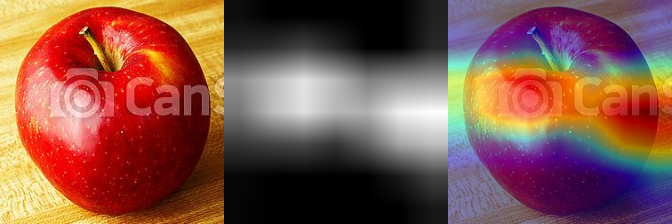

/freshapples/46.jpg


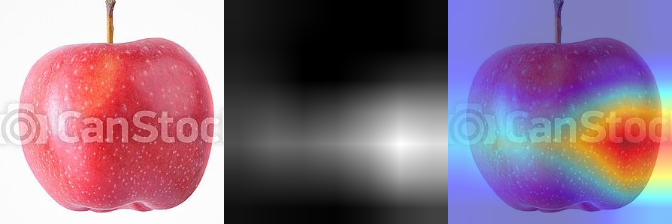

/freshapples/70083966-single-orange-or-yellow-color-apple-or-fruit-with-vitamin-for-healthy-diet-isolated-on-white-backgro.jpg


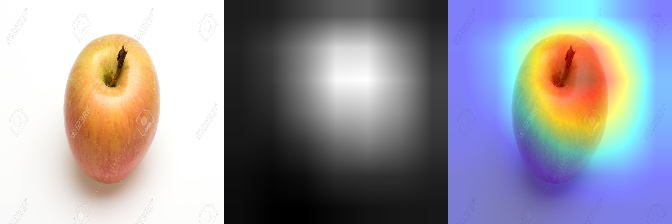

/freshapples/81.jpg


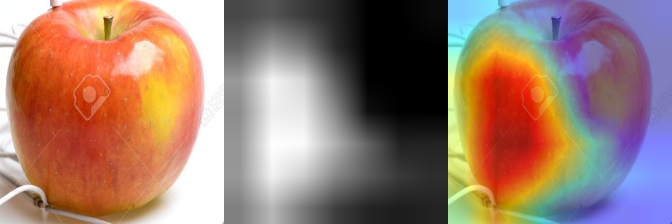

In [424]:
# the false negatives in both lists
print(f'the number of false negatives in both lists are {len(false_negatives_check0_check1)}')

for img_path in false_negatives_check0_check1:
    img = cv2.imread(testset_path0+img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Switch from BGR to RGB
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=[0.6453, 0.4631, 0.3085], std=[0.2000, 0.2238, 0.2254])
    input_tensor = input_tensor.to(device)
    
    camImages=myGradcam(model, input_tensor,1)
    for img in camImages:
        print(img_path)
        display(img)



the number of false negatives in both lists are 1
/freshapples/images (3).jpg


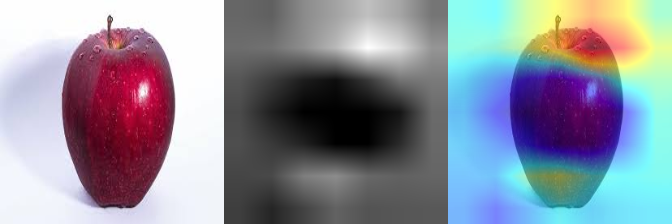

In [426]:
# the false negatives the 0th list
print(f'the number of false negatives in both lists are {len(false_negatives_check0_unique)}')

for img_path in false_negatives_check0_unique:
    img = cv2.imread(testset_path0+img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Switch from BGR to RGB
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=[0.6453, 0.4631, 0.3085], std=[0.2000, 0.2238, 0.2254])
    input_tensor = input_tensor.to(device)
    
    camImages=myGradcam(model, input_tensor,1)
    for img in camImages:
        print(img_path)
        display(img)

the number of false negatives in both lists are 1
/freshapples/23.jpg


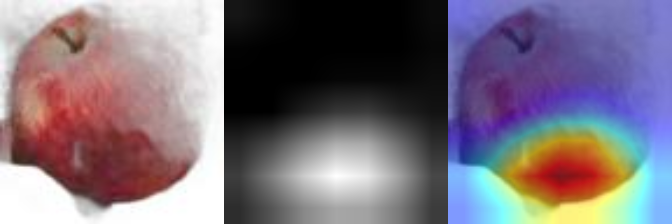

In [432]:
# the false negatives the 1th list
print(f'the number of false negatives in both lists are {len(false_negatives_check1_unique)}')

for img_path in false_negatives_check1_unique:
    img = cv2.imread(testset_path1+img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Switch from BGR to RGB
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=[0.6453, 0.4631, 0.3085], std=[0.2000, 0.2238, 0.2254])
    input_tensor = input_tensor.to(device)
    
    camImages=myGradcam(model, input_tensor,1)
    for img in camImages:
        print(img_path)
        display(img)

# false positives


the number of false positives in both lists are 4
/rottenapples/125.jpg


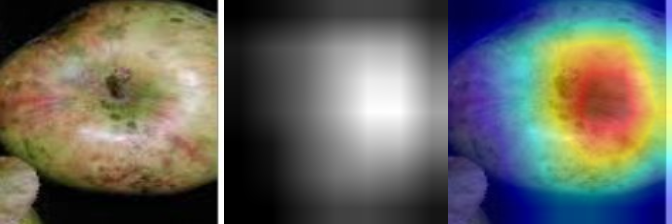

/rottenapples/127.jpg


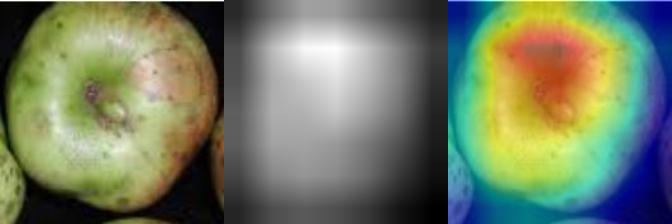

/rottenapples/pg4fhm.jpg


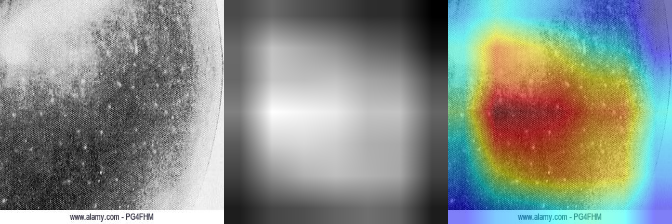

/rottenapples/rp3fh8.jpg


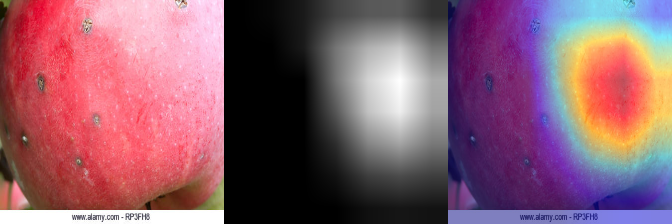

In [428]:
# the false positives in both lists
print(f'the number of false positives in both lists are {len(false_positives_check0_check1)}')

for img_path in false_positives_check0_check1:
    img = cv2.imread(testset_path0+img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Switch from BGR to RGB
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=[0.6453, 0.4631, 0.3085], std=[0.2000, 0.2238, 0.2254])
    input_tensor = input_tensor.to(device)
    
    camImages=myGradcam(model, input_tensor,0)
    for img in camImages:
        print(img_path)
        display(img)

the number of false positives in the 0th list is 2
/rottenapples/133.jpg


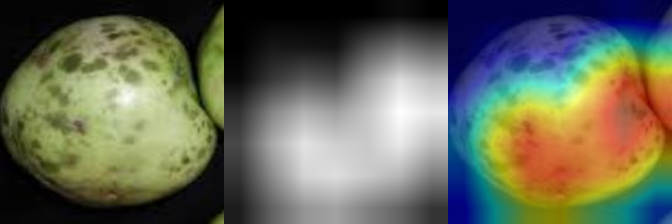

/rottenapples/AnyConv.com__images (90).jpg


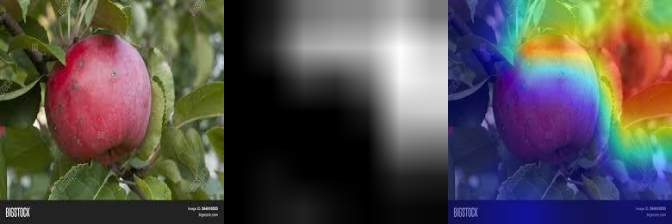

In [430]:
# the false positives in the 0th list
print (f'the number of false positives in the 0th list is {len(false_positives_check0_unique)}')
       
for img_path in false_positives_check0_unique:
    img = cv2.imread(testset_path0+img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Switch from BGR to RGB
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=[0.6453, 0.4631, 0.3085], std=[0.2000, 0.2238, 0.2254])
    input_tensor = input_tensor.to(device)
    
    camImages=myGradcam(model, input_tensor,0)
    for img in camImages:
        print(img_path)
        display(img)

the number of false positives in the 1st list is 3
/rottenapples/136.jpg


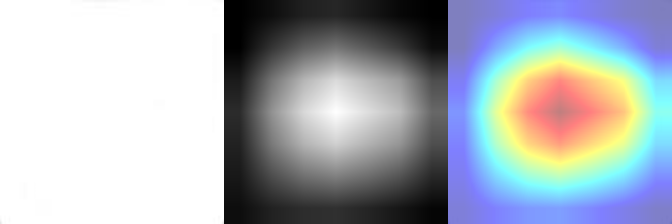

/rottenapples/138.jpg


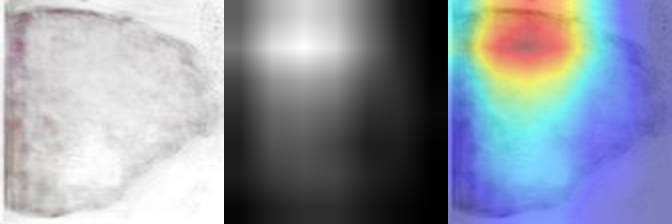

/rottenapples/141.jpg


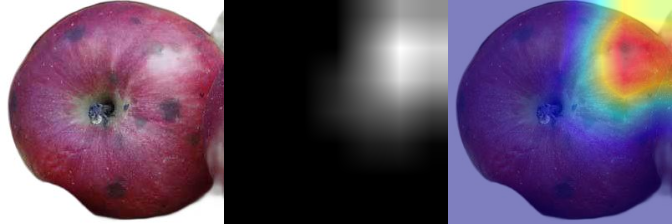

In [433]:
# the false positices in the 1st list
print (f'the number of false positives in the 1st list is {len(false_positives_check1_unique)}')
for img_path in false_positives_check1_unique:
    img = cv2.imread(testset_path1+img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Switch from BGR to RGB
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=[0.6453, 0.4631, 0.3085], std=[0.2000, 0.2238, 0.2254])
    input_tensor = input_tensor.to(device)
    
    camImages=myGradcam(model, input_tensor,0)
    for img in camImages:
        print(img_path)
        display(img)

# WIP display the unique false positives/negatives side by side with its correct counterpart.